<a href="https://colab.research.google.com/github/peanut4556/CITS4012_NLP/blob/main/%E3%80%8CCITS4012_GROUP45_ipynb%E3%80%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2025 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
# ==== Cell 1: env & seed (deterministic) ====
import os, json, math, random, re
import numpy as np
import torch

SEED = 4012
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)

def set_global_seed(seed:int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)


DEVICE: cuda


In [ ]:
# ==== Cell 2: load data (robust JSON/JSONL/columnar JSON) ====
import json, re
from pathlib import Path

def _columnar_to_list(obj):
    keys = obj["premise"].keys()
    try:
        order = sorted(keys, key=lambda k: int(k))
    except Exception:
        order = list(keys)
    out = []
    for k in order:
        out.append({
            "premise": obj["premise"].get(k, ""),
            "hypothesis": obj["hypothesis"].get(k, ""),
            "label": obj["label"].get(k, None) if isinstance(obj.get("label"), dict) else obj.get("label")
        })
    return out

def read_any(path: str):
    with open(path, "r", encoding="utf-8") as f:
        txt = f.read().strip()
    try:
        obj = json.loads(txt)
        if isinstance(obj, list):
            return obj
        if isinstance(obj, dict) and all(k in obj for k in ("premise","hypothesis","label")) \
           and all(isinstance(obj[k], dict) for k in ("premise","hypothesis","label")):
            return _columnar_to_list(obj)
        return [obj]
    except json.JSONDecodeError:
        pass
    data = []
    for line in txt.splitlines():
        line = line.strip()
        if not line: continue
        data.append(json.loads(line))
    return data

def _find_first(base: Path, *names: str) -> Path:
    for nm in names:
        p = base / nm
        if p.exists(): return p
    for p in base.rglob("*"):
        if p.is_file() and p.name in names:
            return p
    raise FileNotFoundError(f"Cannot find any of {names} under {base}")

def load_splits_from_colab(base_hint: str = "/content"):
    base = Path(base_hint)
    train_p = _find_first(base, "train.json", "train.jsonl")
    valid_p = _find_first(base, "validation.json", "val.json", "dev.json",
                          "validation.jsonl", "val.jsonl", "dev.jsonl")
    test_p  = _find_first(base, "test.json", "test.jsonl")
    train = read_any(str(train_p)); valid = read_any(str(valid_p)); test  = read_any(str(test_p))
    print("✔ Using files:"); print("  train:", train_p); print("  valid:", valid_p); print("  test :", test_p)
    print("Counts:", len(train), len(valid), len(test))
    for name, arr in [("train", train), ("valid", valid), ("test", test)]:
        ex = arr[0] if arr else {}
        print(f"Sample [{name}]:", {k: type(ex.get(k)).__name__ for k in ("premise","hypothesis","label")})
    return train, valid, test

train_raw, valid_raw, test_raw = load_splits_from_colab("/content")


✔ Using files:
  train: /content/train.json
  valid: /content/validation.json
  test : /content/test.json
Counts: 23088 1304 2126
Sample [train]: {'premise': 'str', 'hypothesis': 'str', 'label': 'str'}
Sample [valid]: {'premise': 'str', 'hypothesis': 'str', 'label': 'str'}
Sample [test]: {'premise': 'str', 'hypothesis': 'str', 'label': 'str'}


In [ ]:
# ==== Cell 3: tokenizer & vocab ====
import re
from collections import Counter

TOKEN_RE = re.compile(r"\w+|[^\w\s]", flags=re.UNICODE)

def simple_tok(text):
    if not isinstance(text, str):
        text = "" if text is None else str(text)
    return TOKEN_RE.findall(text.lower())

PAD, UNK = "<PAD>", "<UNK>"

def build_vocab(examples, min_freq=2, max_size=50000):
    cnt = Counter()
    for ex in examples:
        cnt.update(simple_tok(ex.get("premise", "")))
        cnt.update(simple_tok(ex.get("hypothesis", "")))
    items = [(w, f) for w, f in cnt.items() if f >= min_freq]
    items.sort(key=lambda x: (-x[1], x[0]))
    items = items[:max_size-2]
    stoi = {PAD: 0, UNK: 1}
    for w, _ in items:
        stoi[w] = len(stoi)
    itos = {i: w for w, i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(train_raw, min_freq=2, max_size=50000)
vocab_size = len(stoi)
print("vocab_size:", vocab_size, "sample:", list(stoi.items())[:10])

label2id = {"neutral": 0, "entails": 1}
def encode_label(y):
    if y is None: return -1
    if isinstance(y, str): return label2id[y]
    if isinstance(y, int): return y
    return -1


vocab_size: 11372 sample: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('.', 3), ('of', 4), (',', 5), ('a', 6), ('is', 7), ('and', 8), ('in', 9)]


In [ ]:
# ==== Cell 4: optional GloVe ====
import numpy as np

def load_glove_txt(glove_path, dim=100):
    vecs = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            if len(parts) < dim + 1: continue
            w = parts[0]
            v = np.asarray(parts[1:], dtype="float32")
            if v.shape[0] == dim:
                vecs[w] = v
    return vecs

def build_embedding_matrix(stoi, glove=None, dim=100):
    emb = np.random.normal(0, 0.1, size=(len(stoi), dim)).astype("float32")
    emb[0] = 0.0
    if glove is not None:
        hit = 0
        for w, i in stoi.items():
            if w in glove:
                emb[i] = glove[w]; hit += 1
        print(f"glove hit {hit}/{len(stoi)}")
    return emb

USE_GLOVE = False
EMB_DIM   = 100
emb_matrix = None
if USE_GLOVE:
    glove = load_glove_txt("/content/glove.6B.100d.txt", dim=EMB_DIM)
    emb_matrix = build_embedding_matrix(stoi, glove, dim=EMB_DIM)


In [ ]:
# ==== Cell 5: dataset & dataloader (deterministic) ====
import torch
from torch.utils.data import Dataset, DataLoader

def encode_tokens(tokens, stoi):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

class NLIPairs(Dataset):
    def __init__(self, rows, stoi):
        self.rows = rows
        self.stoi = stoi
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        ex = self.rows[idx]
        p = encode_tokens(simple_tok(ex.get("premise","")), self.stoi)
        h = encode_tokens(simple_tok(ex.get("hypothesis","")), self.stoi)
        y = encode_label(ex.get("label"))
        return p, h, y

def pad_to_len(ids, L, pad=0): return ids[:L] + [pad] * max(0, L - len(ids))

MAX_P, MAX_H = 64, 32

def collate_fn(batch):
    Ps, Hs, Ys = [], [], []
    for p, h, y in batch:
        Ps.append(pad_to_len(p, MAX_P))
        Hs.append(pad_to_len(h, MAX_H))
        Ys.append(y if y is not None else -1)
    Ps = torch.tensor(Ps, dtype=torch.long)
    Hs = torch.tensor(Hs, dtype=torch.long)
    Ys = torch.tensor(Ys, dtype=torch.long)
    return Ps, Hs, Ys

train_ds = NLIPairs(train_raw, stoi)
valid_ds = NLIPairs(valid_raw, stoi)
test_ds  = NLIPairs(test_raw,  stoi)

BATCH = 128
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  collate_fn=collate_fn,
                          num_workers=0, generator=g, drop_last=False)
valid_loader = DataLoader(valid_ds, batch_size=BATCH, shuffle=False, collate_fn=collate_fn,
                          num_workers=0, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, collate_fn=collate_fn,
                          num_workers=0, drop_last=False)

print("batches:", len(train_loader), len(valid_loader), len(test_loader))


batches: 181 11 17


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
# ==== Cell 6: Model A (Siamese BiLSTM with pooling) ====
import torch.nn as nn
import torch

class SentenceEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid, emb_matrix=None, dropout=0.3, pool_mode='concat'):
        super().__init__()
        assert pool_mode in ('concat','max','mean','last')
        self.pool_mode = pool_mode
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if emb_matrix is not None:
            self.emb.weight.data.copy_(torch.tensor(emb_matrix))
        self.lstm = nn.LSTM(emb_dim, hid, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.out_dim = 6*hid if pool_mode=='concat' else 2*hid

    def forward(self, x):
        e = self.drop(self.emb(x))
        o, (h_n, _) = self.lstm(e)
        max_pool, _ = torch.max(o, dim=1)
        mean_pool   = torch.mean(o, dim=1)
        last = torch.cat([h_n[-2], h_n[-1]], dim=1)
        if self.pool_mode == 'concat':
            return torch.cat([max_pool, mean_pool, last], dim=1)
        elif self.pool_mode == 'max':
            return max_pool
        elif self.pool_mode == 'mean':
            return mean_pool
        else:
            return last

class SiameseBiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hid=128, emb_matrix=None,
                 dropout=0.3, num_classes=2, pool_mode='concat'):
        super().__init__()
        self.enc = SentenceEncoder(vocab_size, emb_dim, hid, emb_matrix, dropout, pool_mode)
        rep_dim = self.enc.out_dim
        in_dim = rep_dim*4
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, P, H):
        u = self.enc(P); v = self.enc(H)
        diff = torch.abs(u - v); prod = u * v
        x = torch.cat([u, v, diff, prod], dim=1)
        return self.mlp(x)

DROPOUT = 0.3
HID     = 128
POOL_MODE = 'concat'
model = SiameseBiLSTM(vocab_size=vocab_size, emb_dim=EMB_DIM, hid=HID,
                      emb_matrix=emb_matrix, dropout=DROPOUT, pool_mode=POOL_MODE).to(DEVICE)
print("params:", sum(p.numel() for p in model.parameters()))


params: 2159922


In [ ]:
# ==== Cell 7: training utils (shared) ====
import torch.nn.functional as F
import torch

RUN_ID = "A_v1_seed4012_len64x32"
USE_CLASS_WEIGHTS = False
LABEL_SMOOTH = 0.0

def class_weights_from(dataset):
    ys=[]
    for i in range(len(dataset)):
        _,_,y = dataset[i]
        ys.append(int(y))
    ys=np.array(ys)
    cnt=np.bincount(ys, minlength=2)
    w = cnt.sum()/(cnt + 1e-12)
    return torch.tensor(w, dtype=torch.float32)

CLASS_WEIGHTS = class_weights_from(train_ds).to(DEVICE) if USE_CLASS_WEIGHTS else None
print("RUN:", RUN_ID, "| class-weights:", (CLASS_WEIGHTS.cpu().numpy() if CLASS_WEIGHTS is not None else "None"),
      "| label_smoothing:", LABEL_SMOOTH)

def accuracy(logits, y):
    return (logits.argmax(1)==y).float().mean().item()

def run_epoch(model, loader, opt=None, class_weights=None, label_smooth=0.0):
    is_train = opt is not None
    model.train(is_train)
    total_loss=total_acc=total_n=0.0
    for P,H,Y in loader:
        P,H,Y = P.to(DEVICE), H.to(DEVICE), Y.to(DEVICE)
        logits = model(P,H)
        loss = F.cross_entropy(logits, Y, weight=class_weights, label_smoothing=label_smooth)
        if is_train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        b = Y.size(0)
        total_loss += loss.item()*b
        total_acc  += accuracy(logits,Y)*b
        total_n    += b
    return total_loss/total_n, total_acc/total_n

def fit(model, train_loader, valid_loader, epochs=30, lr=1e-3, weight_decay=1e-5, patience=5,
        class_weights=None, label_smooth=0.0):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val=-1.0; best_state=None; bad=0; hist=[]
    for ep in range(1,epochs+1):
        tr_loss,tr_acc = run_epoch(model, train_loader, opt, class_weights, label_smooth)
        va_loss,va_acc = run_epoch(model, valid_loader, None, class_weights, label_smooth)
        hist.append((ep,tr_loss,tr_acc,va_loss,va_acc))
        print(f"[Ep {ep:02d}] train loss {tr_loss:.4f} acc {tr_acc:.4f} | valid loss {va_loss:.4f} acc {va_acc:.4f}")
        if va_acc>best_val:
            best_val=va_acc; best_state={k:v.clone() for k,v in model.state_dict().items()}; bad=0
        else:
            bad+=1
            if bad>=patience:
                print("Early stopping."); break
    if best_state is not None: model.load_state_dict(best_state)
    return hist,best_val,best_state

def evaluate_with_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for P, H, Y in loader:
            P, H, Y = P.to(DEVICE), H.to(DEVICE), Y.to(DEVICE)
            logits = model(P, H)
            pred = logits.argmax(1)
            y_true.append(Y.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = (y_true == y_pred).mean()
    return acc, y_true, y_pred

EPOCHS=30; LR=1e-3; WEIGHT_DECAY=1e-5; PATIENCE=5
hist,best_val,best_state = fit(model, train_loader, valid_loader, EPOCHS, LR, WEIGHT_DECAY, PATIENCE,
                               class_weights=CLASS_WEIGHTS, label_smooth=LABEL_SMOOTH)
print("best valid acc:", best_val)

ckpt_path="/content/modelA_best.pt"
torch.save(model.state_dict(), ckpt_path)
print(f"Saved best checkpoint -> {ckpt_path}")


RUN: A_v1_seed4012_len64x32 | class-weights: None | label_smoothing: 0.0


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Ep 01] train loss 0.5413 acc 0.7206 | valid loss 0.5226 acc 0.7370
[Ep 02] train loss 0.4168 acc 0.8089 | valid loss 0.4884 acc 0.7615
[Ep 03] train loss 0.3487 acc 0.8476 | valid loss 0.4399 acc 0.7791
[Ep 04] train loss 0.3038 acc 0.8691 | valid loss 0.4966 acc 0.7630
[Ep 05] train loss 0.2723 acc 0.8859 | valid loss 0.4968 acc 0.7807
[Ep 06] train loss 0.2470 acc 0.8995 | valid loss 0.4699 acc 0.7845
[Ep 07] train loss 0.2150 acc 0.9127 | valid loss 0.5213 acc 0.7745
[Ep 08] train loss 0.1958 acc 0.9215 | valid loss 0.5763 acc 0.7730
[Ep 09] train loss 0.1762 acc 0.9296 | valid loss 0.5939 acc 0.7822
[Ep 10] train loss 0.1554 acc 0.9393 | valid loss 0.5444 acc 0.7899
[Ep 11] train loss 0.1378 acc 0.9447 | valid loss 0.5444 acc 0.7876
[Ep 12] train loss 0.1254 acc 0.9503 | valid loss 0.5933 acc 0.7853
[Ep 13] train loss 0.1173 acc 0.9543 | valid loss 0.6590 acc 0.7776
[Ep 14] train loss 0.1076 acc 0.9593 | valid loss 0.7012 acc 0.7676
[Ep 15] train loss 0.0926 acc 0.9634 | valid los

In [ ]:
# ==== Cell 9: Model C (ESIM-style Cross-Attention) ====
import math, torch.nn as nn, torch

def masked_softmax(scores, mask, dim=-1):
    scores = scores.masked_fill(~mask, float('-inf'))
    return torch.softmax(scores, dim=dim)

class ESIMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hid=128, emb_matrix=None,
                 dropout=0.3, num_classes=2, attn_type='dot', use_cross_attn=True,
                 attn_dim=None, proj_out_dim=None, use_layernorm=False):
        super().__init__()
        self.hid = hid
        self.use_cross_attn = use_cross_attn
        self.attn_type = attn_type

        self.enc_out = 2*hid
        self.align_cat = 4*self.enc_out
        self.proj_out = proj_out_dim or (2*hid)
        self.pool_feat = 4*self.enc_out

        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if emb_matrix is not None:
            self.emb.weight.data.copy_(torch.tensor(emb_matrix))
        self.enc = nn.LSTM(emb_dim, hid, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(dropout)

        if attn_type == 'add':
            A = attn_dim or hid
            self.Wq = nn.Linear(self.enc_out, A, bias=False)
            self.Wk = nn.Linear(self.enc_out, A, bias=False)
            self.v  = nn.Linear(A, 1, bias=False)

        self.proj = nn.Sequential(nn.Linear(self.align_cat, self.proj_out),
                                  nn.ReLU(), nn.Dropout(dropout))
        self.ln = nn.LayerNorm(self.proj_out) if use_layernorm else nn.Identity()
        self.comp = nn.LSTM(self.proj_out, hid, batch_first=True, bidirectional=True)

        self.mlp = nn.Sequential(nn.Linear(self.pool_feat, 256),
                                 nn.ReLU(), nn.Dropout(dropout),
                                 nn.Linear(256, num_classes))

    def _encode(self, x):
        e = self.drop(self.emb(x))
        o, _ = self.enc(e)
        return o

    def _attn_scores(self, Q, K):
        if self.attn_type == 'dot':
            scale = math.sqrt(Q.size(-1))
            return torch.bmm(Q, K.transpose(1,2)) / scale
        elif self.attn_type == 'add':
            Qp = self.Wq(Q).unsqueeze(2)
            Kp = self.Wk(K).unsqueeze(1)
            return self.v(torch.tanh(Qp + Kp)).squeeze(-1)
        else:
            raise ValueError(self.attn_type)

    def forward(self, P, H, return_attn=False):
        mask_p = (P!=0); mask_h=(H!=0)
        P_enc = self._encode(P); H_enc = self._encode(H)

        if self.use_cross_attn:
            S = self._attn_scores(P_enc, H_enc)
            A = masked_softmax(S, mask_h.unsqueeze(1), dim=2)
            P_att = torch.bmm(A, H_enc)
            S_T = S.transpose(1,2)
            B = masked_softmax(S_T, mask_p.unsqueeze(1), dim=2)
            H_att = torch.bmm(B, P_enc)
        else:
            P_att = torch.zeros_like(P_enc); H_att = torch.zeros_like(H_enc); A=None

        P_cat = torch.cat([P_enc, P_att, P_enc-P_att, P_enc*P_att], dim=-1)
        H_cat = torch.cat([H_enc, H_att, H_enc-H_att, H_enc*H_att], dim=-1)

        P_proj = self.ln(self.proj(P_cat))
        H_proj = self.ln(self.proj(H_cat))
        P_comp, _ = self.comp(P_proj)
        H_comp, _ = self.comp(H_proj)

        def masked_pool(x, mask):
            mask = mask.unsqueeze(-1)
            x = x.masked_fill(~mask, 0.0)
            lengths = mask.sum(dim=1).clamp(min=1)
            mean = x.sum(dim=1)/lengths
            x_masked = x.masked_fill(~mask, float('-inf'))
            maxv,_ = x_masked.max(dim=1)
            maxv = torch.where(torch.isfinite(maxv), maxv, torch.zeros_like(maxv))
            return mean, maxv

        p_mean, p_max = masked_pool(P_comp, mask_p)
        h_mean, h_max = masked_pool(H_comp, mask_h)
        feat = torch.cat([p_mean, p_max, h_mean, h_max], dim=-1)
        logits = self.mlp(feat)
        return (logits, A) if return_attn else logits


In [ ]:
# ==== Cell 10: Train Model C (main run) ====
HID_C = HID
DROPOUT_C = 0.3
ATTN_TYPE_C = 'dot'
ATTN_DIM_C  = HID_C
PROJ_OUT_DIM_C = 2*HID_C
USE_LN_C = False

modelC = ESIMClassifier(
    vocab_size=vocab_size, emb_dim=EMB_DIM, hid=HID_C,
    emb_matrix=emb_matrix, dropout=DROPOUT_C, num_classes=2,
    attn_type=ATTN_TYPE_C, use_cross_attn=True,
    attn_dim=ATTN_DIM_C, proj_out_dim=PROJ_OUT_DIM_C, use_layernorm=USE_LN_C
).to(DEVICE)

print("Model C params:", sum(p.numel() for p in modelC.parameters()))

histC, best_valC, best_stateC = fit(
    modelC, train_loader, valid_loader,
    epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    class_weights=None, label_smooth=0.0
)
print("best valid acc (C):", best_valC)

ckpt_c = "/content/modelC_best.pt"
torch.save(modelC.state_dict(), ckpt_c)
print(f"Saved Model C checkpoint -> {ckpt_c}")


Model C params: 2293298


/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(Q, K.transpose(1,2)) / scale
/tmp/ipython-input-1567827658.py:66: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior

[Ep 01] train loss 0.5528 acc 0.7113 | valid loss 0.6176 acc 0.6940
[Ep 02] train loss 0.4223 acc 0.8073 | valid loss 0.7591 acc 0.6702
[Ep 03] train loss 0.3624 acc 0.8393 | valid loss 0.5522 acc 0.7354
[Ep 04] train loss 0.3167 acc 0.8653 | valid loss 0.6268 acc 0.7094
[Ep 05] train loss 0.2835 acc 0.8820 | valid loss 0.5952 acc 0.7423
[Ep 06] train loss 0.2576 acc 0.8939 | valid loss 0.6341 acc 0.7339
[Ep 07] train loss 0.2272 acc 0.9066 | valid loss 0.5908 acc 0.7439
[Ep 08] train loss 0.2053 acc 0.9161 | valid loss 0.5974 acc 0.7546
[Ep 09] train loss 0.1834 acc 0.9271 | valid loss 0.5798 acc 0.7607
[Ep 10] train loss 0.1609 acc 0.9356 | valid loss 0.6968 acc 0.7584
[Ep 11] train loss 0.1454 acc 0.9423 | valid loss 0.6627 acc 0.7584
[Ep 12] train loss 0.1270 acc 0.9511 | valid loss 0.7533 acc 0.7538
[Ep 13] train loss 0.1106 acc 0.9552 | valid loss 0.8375 acc 0.7500
[Ep 14] train loss 0.0974 acc 0.9620 | valid loss 0.7921 acc 0.7462
Early stopping.
best valid acc (C): 0.7607361963

In [ ]:
# ==== Cell 17: Model B (BiLSTM -> similarity maps -> 2D-CNN) ====
import torch.nn.functional as F
import torch.nn as nn
import torch

class BiLSTM2DCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hid=128, pad_idx=0,
                 use_cos=True, use_dot=False, use_bilinear=False,
                 num_filters=32, kernel_size=3, pool_out=16,
                 dropout=0.3, standardize=True):
        super().__init__()
        self.pad_idx = pad_idx
        self.use_cos, self.use_dot, self.use_bilinear = use_cos, use_dot, use_bilinear
        self.standardize = standardize

        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.emb_drop = nn.Dropout(0.1)
        self.enc = nn.LSTM(emb_dim, hid, batch_first=True, bidirectional=True)

        if use_bilinear:
            self.Wa = nn.Linear(2*hid, 2*hid, bias=False)

        in_ch = (1 if use_cos else 0) + (1 if use_dot else 0) + (1 if use_bilinear else 0)
        assert in_ch > 0, "At least one similarity channel must be enabled."

        self.conv1 = nn.Conv2d(in_ch, num_filters, kernel_size, padding=kernel_size//2)
        self.bn1   = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
        self.bn2   = nn.BatchNorm2d(num_filters)
        self.act   = nn.LeakyReLU(0.01, inplace=True)
        self.pool  = nn.AdaptiveMaxPool2d((pool_out, pool_out))

        fc_in = num_filters * pool_out * pool_out
        self.mlp = nn.Sequential(
            nn.Linear(fc_in, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)
        )

    def _encode(self, x):
        e = self.emb_drop(self.emb(x))
        o, _ = self.enc(e)
        on = F.normalize(o, p=2, dim=-1)
        return on, o

    def _build_maps(self, Pn, Hn, Pr, Hr):
        maps = []
        if self.use_cos:
            maps.append(torch.einsum("bid,bjd->bij", Pn, Hn).unsqueeze(1))
        if self.use_dot:
            scale = (Pr.size(-1) ** 0.5)
            maps.append(torch.einsum("bid,bjd->bij", Pr, Hr).unsqueeze(1) / scale)
        if self.use_bilinear:
            Pw = self.Wa(Pr)
            maps.append(torch.einsum("bid,bjd->bij", Pw, Hr).unsqueeze(1))
        return torch.cat(maps, dim=1)

    def _pad_mask2d(self, P, H):
        pm = (P != self.pad_idx).float()
        hm = (H != self.pad_idx).float()
        return torch.bmm(pm.unsqueeze(2), hm.unsqueeze(1))  # (B, Lp, Lh)

    def forward(self, P, H, return_maps=False):
        Pn, Pr = self._encode(P)
        Hn, Hr = self._encode(H)
        S = self._build_maps(Pn, Hn, Pr, Hr)

        mask2d = self._pad_mask2d(P, H).unsqueeze(1)
        S = S * mask2d

        if self.standardize:
            valid = mask2d.sum(dim=(2,3), keepdim=True).clamp_min(1.0)
            mean  = (S * mask2d).sum(dim=(2,3), keepdim=True) / valid
            var   = ((S - mean) * mask2d) ** 2
            std   = (var.sum(dim=(2,3), keepdim=True) / valid).sqrt().clamp_min(1e-6)
            S = (S - mean) / std

        x = self.act(self.bn1(self.conv1(S)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.pool(x).flatten(1)
        logits = self.mlp(x)
        return (logits, S) if return_maps else logits


In [ ]:
# ==== Cell 18: Train Model B (main) ====
DROPOUT_B   = 0.3
HID_B       = HID
USE_COS_B   = True
USE_DOT_B   = False   # set True if you want cos+dot as main
USE_BIL_B   = False
NFILTER_B   = 32
KSIZE_B     = 3       # set 5 if you want kernel5 as main
POOL_OUT_B  = 16

modelB = BiLSTM2DCNN(
    vocab_size=len(stoi),
    emb_dim=EMB_DIM,
    hid=HID_B,
    pad_idx=stoi[PAD],
    use_cos=USE_COS_B, use_dot=USE_DOT_B, use_bilinear=USE_BIL_B,
    num_filters=NFILTER_B, kernel_size=KSIZE_B, pool_out=POOL_OUT_B,
    dropout=DROPOUT_B, standardize=True
).to(DEVICE)

print("Model B params:", sum(p.numel() for p in modelB.parameters()))

histB, best_valB, best_stateB = fit(
    modelB, train_loader, valid_loader,
    epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    class_weights=None, label_smooth=0.0
)
print("best valid acc (B):", best_valB)

ckpt_b = "/content/modelB_best.pt"
torch.save(modelB.state_dict(), ckpt_b)
print(f"Saved Model B checkpoint -> {ckpt_b}")


Model B params: 3480338


/usr/local/lib/python3.12/dist-packages/torch/functional.py:422: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return _VF.einsum(equation, operands)  # type: ignore[attr-defined]
/tmp/ipython-input-3648102403.py:62: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you h

[Ep 01] train loss 0.6627 acc 0.7025 | valid loss 0.6330 acc 0.6848
[Ep 02] train loss 0.4107 acc 0.8198 | valid loss 0.6554 acc 0.6848
[Ep 03] train loss 0.3281 acc 0.8645 | valid loss 0.6206 acc 0.7086
[Ep 04] train loss 0.2663 acc 0.8936 | valid loss 0.7201 acc 0.7086
[Ep 05] train loss 0.2128 acc 0.9192 | valid loss 0.9265 acc 0.7078
[Ep 06] train loss 0.1737 acc 0.9343 | valid loss 0.9887 acc 0.7055
[Ep 07] train loss 0.1427 acc 0.9471 | valid loss 0.8861 acc 0.7270
[Ep 08] train loss 0.1083 acc 0.9600 | valid loss 1.1328 acc 0.7109
[Ep 09] train loss 0.0799 acc 0.9710 | valid loss 1.5624 acc 0.7086
[Ep 10] train loss 0.0713 acc 0.9749 | valid loss 1.8460 acc 0.6971
[Ep 11] train loss 0.0599 acc 0.9795 | valid loss 1.7233 acc 0.7048
[Ep 12] train loss 0.0530 acc 0.9818 | valid loss 1.6725 acc 0.6910
Early stopping.
best valid acc (B): 0.7269938653963475
Saved Model B checkpoint -> /content/modelB_best.pt


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
# ==== Cell 8: Test Model A + CM + Macro P/R/F1 ====
import numpy as np

test_acc, y_true, y_pred = evaluate_with_preds(model, test_loader)
print("TEST ACC:", round(test_acc, 4))

cm = np.zeros((2, 2), dtype=int)
for t, p in zip(y_true, y_pred): cm[t, p] += 1
print("Confusion matrix:\n", cm)

prec, rec, f1 = [], [], []
for c in [0, 1]:
    tp = cm[c, c]; fp = cm[:, c].sum() - tp; fn = cm[c, :].sum() - tp
    p = tp / (tp + fp + 1e-12); r = tp / (tp + fn + 1e-12)
    prec.append(p); rec.append(r); f1.append(2 * p * r / (p + r + 1e-12))
print("Macro-P/R/F1:", round(np.mean(prec), 4), round(np.mean(rec), 4), round(np.mean(f1), 4))


TEST ACC: 0.7817
Confusion matrix:
 [[1083  201]
 [ 263  579]]
Macro-P/R/F1: 0.7735 0.7656 0.7688


In [ ]:
# ==== Cell 11: Test Model C + CM + Macro P/R/F1 ====
accC, y_trueC, y_predC = evaluate_with_preds(modelC, test_loader)
print("TEST ACC (Model C):", round(accC, 4))

cmC = np.zeros((2,2), dtype=int)
for t,p in zip(y_trueC, y_predC): cmC[t,p]+=1
print("Confusion matrix (C):\n", cmC)

prec, rec, f1 = [], [], []
for c in [0,1]:
    tp = cmC[c,c]; fp = cmC[:,c].sum()-tp; fn = cmC[c,:].sum()-tp
    p = tp/(tp+fp+1e-12); r = tp/(tp+fn+1e-12)
    prec.append(p); rec.append(r); f1.append(2*p*r/(p+r+1e-12))
print("Macro-P/R/F1 (C):", round(np.mean(prec),4), round(np.mean(rec),4), round(np.mean(f1),4))


TEST ACC (Model C): 0.7563
Confusion matrix (C):
 [[1140  144]
 [ 374  468]]
Macro-P/R/F1 (C): 0.7588 0.7218 0.7293


/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(Q, K.transpose(1,2)) / scale
/tmp/ipython-input-1567827658.py:66: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior

/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(Q, K.transpose(1,2)) / scale
/tmp/ipython-input-1567827658.py:66: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior

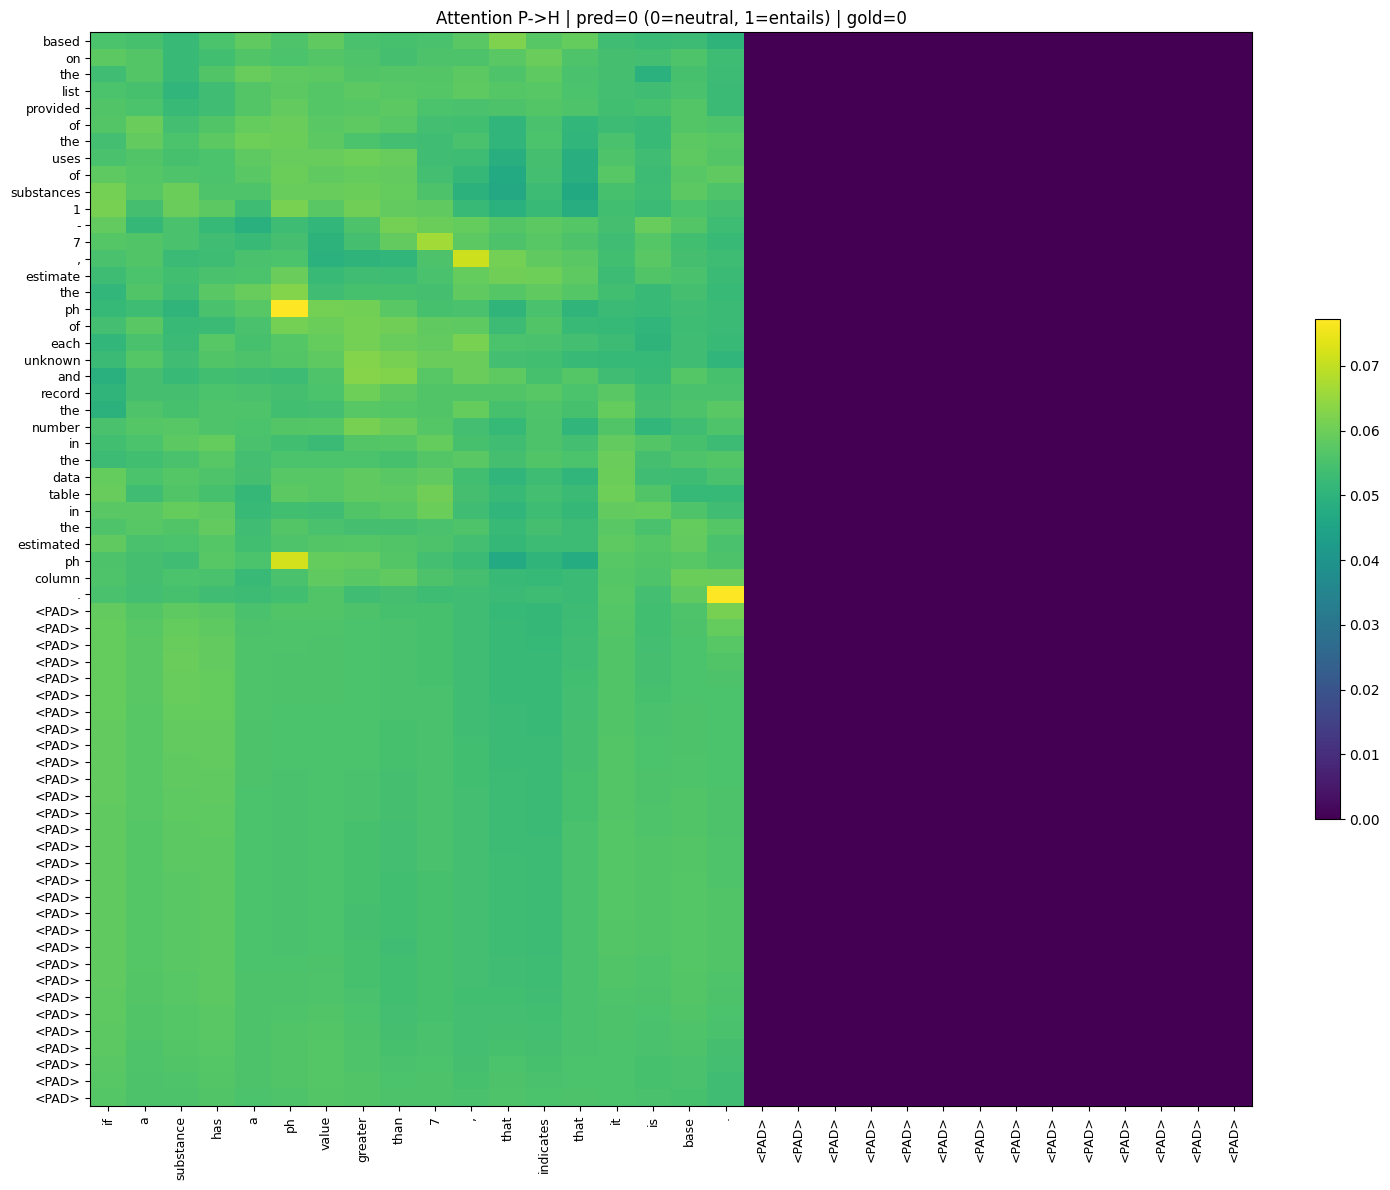

In [ ]:
# ==== Cell 12: Attention heatmap on one example (Model C) ====
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_attention_for_example_modelC(
    model, ex, stoi, itos,
    max_p, max_h, device,
    unk_token='UNK', pad_token='PAD',
    save_path="attn_single_c.png",
    show=True, cmap='viridis'
):
    """
    Render P->H attention for one example using Model C.
    Assumes: model(P, H, return_attn=True) -> (logits, attn[B, Lp, Lh])
    """
    # tokenize & index
    unk_id = stoi.get(unk_token, 0)
    pad_id = stoi.get(pad_token, 0)
    p_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["premise"])]
    h_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["hypothesis"])]

    P = torch.tensor([pad_to_len(p_ids, max_p, pad_id)], dtype=torch.long, device=device)
    H = torch.tensor([pad_to_len(h_ids, max_h, pad_id)], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        logits, attn = model(P, H, return_attn=True)
        pred = int(logits.argmax(1).item())

    def decode(ids):
        toks = [itos.get(i, unk_token) for i in ids]
        try:
            cut = toks.index(pad_token)
            toks = toks[:cut]
        except ValueError:
            pass
        return toks

    p_toks = decode(P[0].tolist())
    h_toks = decode(H[0].tolist())
    A = attn[0].detach().cpu().numpy()[:len(p_toks), :len(h_toks)]

    # figure size adapted to token counts
    fig_w = min(14, 0.5 * len(h_toks) + 4)
    fig_h = min(12, 0.5 * len(p_toks) + 4)
    plt.figure(figsize=(fig_w, fig_h))
    im = plt.imshow(A, aspect='auto', cmap=cmap)
    plt.colorbar(im, fraction=0.020)
    plt.yticks(range(len(p_toks)), p_toks, fontsize=9)
    plt.xticks(range(len(h_toks)), h_toks, rotation=90, fontsize=9)
    title = f"Attention P->H | pred={pred} (0=neutral, 1=entails)"
    if "label" in ex:
        title += f" | gold={encode_label(ex['label'])}"
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# Example call (keeps your variable names):
visualize_attention_for_example_modelC(
    modelC, test_raw[0], stoi, itos,
    max_p=MAX_P, max_h=MAX_H, device=DEVICE,
    save_path="attn_single_c.png", show=True
)


In [ ]:
# ==== Cell 13: Attention ablation runs (4 variants) ====
def train_eval_C_variant(attn_type='dot', use_cross_attn=True):
    m = ESIMClassifier(
        vocab_size=vocab_size, emb_dim=EMB_DIM, hid=HID_C,
        emb_matrix=emb_matrix, dropout=DROPOUT_C, num_classes=2,
        attn_type=attn_type, use_cross_attn=use_cross_attn
    ).to(DEVICE)
    _, v, _ = fit(m, train_loader, valid_loader,
                  epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE,
                  class_weights=None, label_smooth=0.0)
    acc, _, _ = evaluate_with_preds(m, test_loader)
    print(f"Variant | type={attn_type:3s} | cross={use_cross_attn} -> VAL={v:.4f} TEST={acc:.4f}")
    return v, acc

rows = []
for t in ['dot','add']:
    for flag in [True, False]:
        v,a = train_eval_C_variant(attn_type=t, use_cross_attn=flag)
        rows.append((t, flag, round(v,4), round(a,4)))

print("\n| attn_type | cross_attn | Val   | Test  |")
print("|-----------|------------|-------|-------|")
for t,flag,v,a in rows:
    print(f"| {t:9s} | {str(flag):10s} | {v:5.4f} | {a:5.4f} |")


/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(Q, K.transpose(1,2)) / scale
/tmp/ipython-input-1567827658.py:66: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior

[Ep 01] train loss 0.5585 acc 0.7078 | valid loss 0.6408 acc 0.6833
[Ep 02] train loss 0.4172 acc 0.8117 | valid loss 0.5703 acc 0.7109
[Ep 03] train loss 0.3558 acc 0.8446 | valid loss 0.6003 acc 0.7209
[Ep 04] train loss 0.3144 acc 0.8660 | valid loss 0.5863 acc 0.7201
[Ep 05] train loss 0.2788 acc 0.8832 | valid loss 0.5995 acc 0.7370
[Ep 06] train loss 0.2484 acc 0.8999 | valid loss 0.5805 acc 0.7569
[Ep 07] train loss 0.2242 acc 0.9063 | valid loss 0.5752 acc 0.7607
[Ep 08] train loss 0.1980 acc 0.9220 | valid loss 0.6819 acc 0.7500
[Ep 09] train loss 0.1761 acc 0.9296 | valid loss 0.5703 acc 0.7822
[Ep 10] train loss 0.1544 acc 0.9393 | valid loss 0.6733 acc 0.7646
[Ep 11] train loss 0.1381 acc 0.9474 | valid loss 0.6404 acc 0.7699
[Ep 12] train loss 0.1260 acc 0.9505 | valid loss 0.7563 acc 0.7684
[Ep 13] train loss 0.1113 acc 0.9579 | valid loss 0.8216 acc 0.7638
[Ep 14] train loss 0.0997 acc 0.9619 | valid loss 0.7455 acc 0.7684
Early stopping.
Variant | type=dot | cross=True 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)


[Ep 01] train loss 0.5607 acc 0.7043 | valid loss 0.5502 acc 0.7117
[Ep 02] train loss 0.4325 acc 0.7993 | valid loss 0.5288 acc 0.7201
[Ep 03] train loss 0.3580 acc 0.8433 | valid loss 0.4990 acc 0.7400
[Ep 04] train loss 0.3148 acc 0.8653 | valid loss 0.5558 acc 0.7270
[Ep 05] train loss 0.2785 acc 0.8835 | valid loss 0.5234 acc 0.7370
[Ep 06] train loss 0.2528 acc 0.8961 | valid loss 0.5784 acc 0.7316
[Ep 07] train loss 0.2201 acc 0.9089 | valid loss 0.5978 acc 0.7408
[Ep 08] train loss 0.1999 acc 0.9179 | valid loss 0.5987 acc 0.7469
[Ep 09] train loss 0.1769 acc 0.9280 | valid loss 0.6053 acc 0.7523
[Ep 10] train loss 0.1557 acc 0.9373 | valid loss 0.6134 acc 0.7684
[Ep 11] train loss 0.1380 acc 0.9452 | valid loss 0.6502 acc 0.7492
[Ep 12] train loss 0.1243 acc 0.9518 | valid loss 0.6873 acc 0.7577
[Ep 13] train loss 0.1098 acc 0.9574 | valid loss 0.7183 acc 0.7692
[Ep 14] train loss 0.0951 acc 0.9635 | valid loss 0.7731 acc 0.7730
[Ep 15] train loss 0.0892 acc 0.9664 | valid los

In [ ]:
# ==== Cell 14: Model C additional ablations (proj/LN/dropout) ====
import json

def train_eval_C_variant2(attn_type='dot', attn_dim=None, proj_out_dim=None,
                          use_ln=False, dropout=0.3):
    m = ESIMClassifier(
        vocab_size=vocab_size, emb_dim=EMB_DIM, hid=HID_C, emb_matrix=emb_matrix,
        dropout=dropout, num_classes=2, attn_type=attn_type, use_cross_attn=True,
        attn_dim=attn_dim, proj_out_dim=proj_out_dim, use_layernorm=use_ln
    ).to(DEVICE)
    _, v, _ = fit(m, train_loader, valid_loader, EPOCHS, LR, WEIGHT_DECAY, PATIENCE,
                  class_weights=None, label_smooth=0.0)
    acc, _, _ = evaluate_with_preds(m, test_loader)
    print(f"C-abl | type={attn_type:3s} A={attn_dim} proj={proj_out_dim} LN={use_ln} drop={dropout} "
          f"-> VAL={v:.4f} TEST={acc:.4f}")
    return v, acc

rows2 = []
rows2.append(("proj 2H",) + train_eval_C_variant2(attn_type='dot', proj_out_dim=2*HID_C))
rows2.append(("proj 1H",) + train_eval_C_variant2(attn_type='dot', proj_out_dim=HID_C))
rows2.append(("add A=H",) + train_eval_C_variant2(attn_type='add', attn_dim=HID_C))
rows2.append(("add A=2H",) + train_eval_C_variant2(attn_type='add', attn_dim=2*HID_C))
rows2.append(("LN on",)  + train_eval_C_variant2(attn_type='dot', proj_out_dim=2*HID_C, use_ln=True))
rows2.append(("LN off",) + train_eval_C_variant2(attn_type='dot', proj_out_dim=2*HID_C, use_ln=False))
rows2.append(("drop=0.3",)+ train_eval_C_variant2(attn_type='dot', proj_out_dim=2*HID_C, dropout=0.3))
rows2.append(("drop=0.4",)+ train_eval_C_variant2(attn_type='dot', proj_out_dim=2*HID_C, dropout=0.4))

print("\n| variant   | Val   | Test  |")
print("|-----------|-------|-------|")
for name, v, a in rows2:
    print(f"| {name:9s} | {v:5.4f} | {a:5.4f} |")

with open("/content/c_additional_ablation.json", "w", encoding="utf-8") as f:
    json.dump([{"variant":n, "val":v, "test":a} for n,v,a in rows2], f, indent=2)
print("Saved -> /content/c_additional_ablation.json")


/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(Q, K.transpose(1,2)) / scale
/tmp/ipython-input-1567827658.py:66: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior

[Ep 01] train loss 0.5604 acc 0.7070 | valid loss 0.5938 acc 0.6802
[Ep 02] train loss 0.4282 acc 0.8021 | valid loss 0.5371 acc 0.7285
[Ep 03] train loss 0.3635 acc 0.8397 | valid loss 0.5533 acc 0.7224
[Ep 04] train loss 0.3211 acc 0.8613 | valid loss 0.5481 acc 0.7393
[Ep 05] train loss 0.2855 acc 0.8797 | valid loss 0.5492 acc 0.7347
[Ep 06] train loss 0.2545 acc 0.8928 | valid loss 0.6331 acc 0.7385
[Ep 07] train loss 0.2307 acc 0.9033 | valid loss 0.6130 acc 0.7446
[Ep 08] train loss 0.2028 acc 0.9160 | valid loss 0.5688 acc 0.7638
[Ep 09] train loss 0.1823 acc 0.9252 | valid loss 0.5906 acc 0.7607
[Ep 10] train loss 0.1648 acc 0.9345 | valid loss 0.6272 acc 0.7776
[Ep 11] train loss 0.1436 acc 0.9424 | valid loss 0.6501 acc 0.7607
[Ep 12] train loss 0.1322 acc 0.9465 | valid loss 0.5776 acc 0.7830
[Ep 13] train loss 0.1121 acc 0.9568 | valid loss 0.8391 acc 0.7485
[Ep 14] train loss 0.1068 acc 0.9593 | valid loss 0.7634 acc 0.7592
[Ep 15] train loss 0.0908 acc 0.9650 | valid los

In [ ]:
# ==== Cell 15: Pick SUCCESS and FAILURE and plot attention maps (Model C) ====
import torch
import numpy as np
import matplotlib.pyplot as plt

def _visualize_attn_single_modelC(
    model, ex, stoi, itos, max_p, max_h, device,
    unk_token='UNK', pad_token='PAD',
    save_path="attn_example.png", show=False
):
    # same renderer as Cell 12, minimal inline version
    unk_id = stoi.get(unk_token, 0)
    pad_id = stoi.get(pad_token, 0)

    p_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["premise"])]
    h_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["hypothesis"])]
    P = torch.tensor([pad_to_len(p_ids, max_p, pad_id)], dtype=torch.long, device=device)
    H = torch.tensor([pad_to_len(h_ids, max_h, pad_id)], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        logits, attn = model(P, H, return_attn=True)
        pred = int(logits.argmax(1).item())

    def decode(ids):
        toks = [itos.get(i, unk_token) for i in ids]
        try:
            cut = toks.index(pad_token); toks = toks[:cut]
        except ValueError:
            pass
        return toks

    p_toks = decode(P[0].tolist())
    h_toks = decode(H[0].tolist())
    A = attn[0].detach().cpu().numpy()[:len(p_toks), :len(h_toks)]

    fig_w = min(14, 0.5 * len(h_toks) + 4)
    fig_h = min(12, 0.5 * len(p_toks) + 4)
    plt.figure(figsize=(fig_w, fig_h))
    im = plt.imshow(A, aspect='auto', cmap='viridis')
    plt.colorbar(im, fraction=0.020)
    plt.yticks(range(len(p_toks)), p_toks, fontsize=9)
    plt.xticks(range(len(h_toks)), h_toks, rotation=90, fontsize=9)
    title = f"Attention P->H | pred={pred} (0=neutral, 1=entails)"
    if "label" in ex:
        title += f" | gold={encode_label(ex['label'])}"
    plt.title(title)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show: plt.show()
    else: plt.close()

def pick_first_success_failure_indices(model, raw, stoi, itos, device, max_p, max_h,
                                       unk_token='UNK', pad_token='PAD'):
    model.eval()
    preds = []
    unk_id = stoi.get(unk_token, 0)
    pad_id = stoi.get(pad_token, 0)
    with torch.no_grad():
        for ex in raw:
            p_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["premise"])]
            h_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["hypothesis"])]
            P = torch.tensor([pad_to_len(p_ids, max_p, pad_id)], dtype=torch.long, device=device)
            H = torch.tensor([pad_to_len(h_ids, max_h, pad_id)], dtype=torch.long, device=device)
            logits = model(P, H)
            preds.append(int(logits.argmax(1).item()))
    y = np.array([encode_label(ex["label"]) for ex in raw])
    preds = np.array(preds)
    ok_idx  = np.where(preds == y)[0].tolist()
    bad_idx = np.where(preds != y)[0].tolist()
    return (ok_idx[0] if ok_idx else None), (bad_idx[0] if bad_idx else None)

ok_idx, bad_idx = pick_first_success_failure_indices(
    modelC, test_raw, stoi, itos, DEVICE, MAX_P, MAX_H
)

if ok_idx is not None:
    _visualize_attn_single_modelC(
        modelC, test_raw[ok_idx], stoi, itos, MAX_P, MAX_H, DEVICE,
        save_path="attn_success.png", show=False
    )

if bad_idx is not None:
    _visualize_attn_single_modelC(
        modelC, test_raw[bad_idx], stoi, itos, MAX_P, MAX_H, DEVICE,
        save_path="attn_failure.png", show=False
    )


/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(Q, K.transpose(1,2)) / scale
/tmp/ipython-input-1567827658.py:66: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior

In [ ]:
# ==== Cell 16: Auto-generate attention ablation table (no manual input) ====
import json, numpy as np, random, torch

def print_md_table(rows, header):
    print("| " + " | ".join(header) + " |")
    print("|" + "|".join(["-" * (len(h) + 2) for h in header]) + "|")
    for r in rows:
        print("| " + " | ".join(str(x) for x in r) + " |")

def run_attn_variant(attn_type, use_cross_attn):
    m = ESIMClassifier(vocab_size=vocab_size, emb_dim=EMB_DIM, hid=HID,
                       emb_matrix=emb_matrix, dropout=0.3, num_classes=2,
                       attn_type=attn_type, use_cross_attn=use_cross_attn).to(DEVICE)
    torch.manual_seed(4012); np.random.seed(4012); random.seed(4012)
    _, val, _ = fit(m, train_loader, valid_loader, epochs=EPOCHS, lr=LR,
                    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
                    class_weights=None, label_smooth=0.0)
    acc, _, _ = evaluate_with_preds(m, test_loader)
    return round(val, 4), round(acc, 4)

def collect_attn_rows():
    if 'rows' in globals() and isinstance(rows, list) and len(rows) == 4:
        try:
            return [(str(t), bool(flag), float(v), float(a)) for (t, flag, v, a) in rows]
        except Exception:
            pass
    results = []
    for t in ['dot', 'add']:
        for flag in [True, False]:
            v, a = run_attn_variant(t, flag)
            results.append((t, flag, v, a))
    return results

attn_rows = collect_attn_rows()
print_md_table(attn_rows, ["attn_type", "cross_attn", "Val", "Test"])

save_path = "/content/attn_ablation_table.json"
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(
        [{"attn_type": t, "cross_attn": c, "val": v, "test": a} for (t, c, v, a) in attn_rows],
        f, indent=2
    )
print(f"Saved -> {save_path}")


| attn_type | cross_attn | Val | Test |
|-----------|------------|-----|------|
| dot | True | 0.7822 | 0.7596 |
| dot | False | 0.7431 | 0.754 |
| add | True | 0.773 | 0.7469 |
| add | False | 0.7255 | 0.7418 |
Saved -> /content/attn_ablation_table.json


In [ ]:
# ==== Cell 19: Test Model B (single source of truth) ====
accB, y_trueB, y_predB = evaluate_with_preds(modelB, test_loader)
print("TEST ACC (Model B):", round(accB, 4))

cmB = np.zeros((2,2), dtype=int)
for t,p in zip(y_trueB, y_predB): cmB[t,p]+=1
print("Confusion matrix (B):\n", cmB)

prec, rec, f1 = [], [], []
for c in [0,1]:
    tp = cmB[c,c]; fp = cmB[:,c].sum()-tp; fn = cmB[c,:].sum()-tp
    p = tp/(tp+fp+1e-12); r = tp/(tp+fn+1e-12)
    prec.append(p); rec.append(r); f1.append(2*p*r/(p+r+1e-12))
print("Macro-P/R/F1 (B):", round(np.mean(prec),4), round(np.mean(rec),4), round(np.mean(f1),4))


TEST ACC (Model B): 0.738
Confusion matrix (B):
 [[1043  241]
 [ 316  526]]
Macro-P/R/F1 (B): 0.7266 0.7185 0.7215


/usr/local/lib/python3.12/dist-packages/torch/functional.py:422: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return _VF.einsum(equation, operands)  # type: ignore[attr-defined]
/tmp/ipython-input-3648102403.py:62: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you h

/tmp/ipython-input-3648102403.py:62: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(pm.unsqueeze(2), hm.unsqueeze(1))  # (B, Lp, Lh)


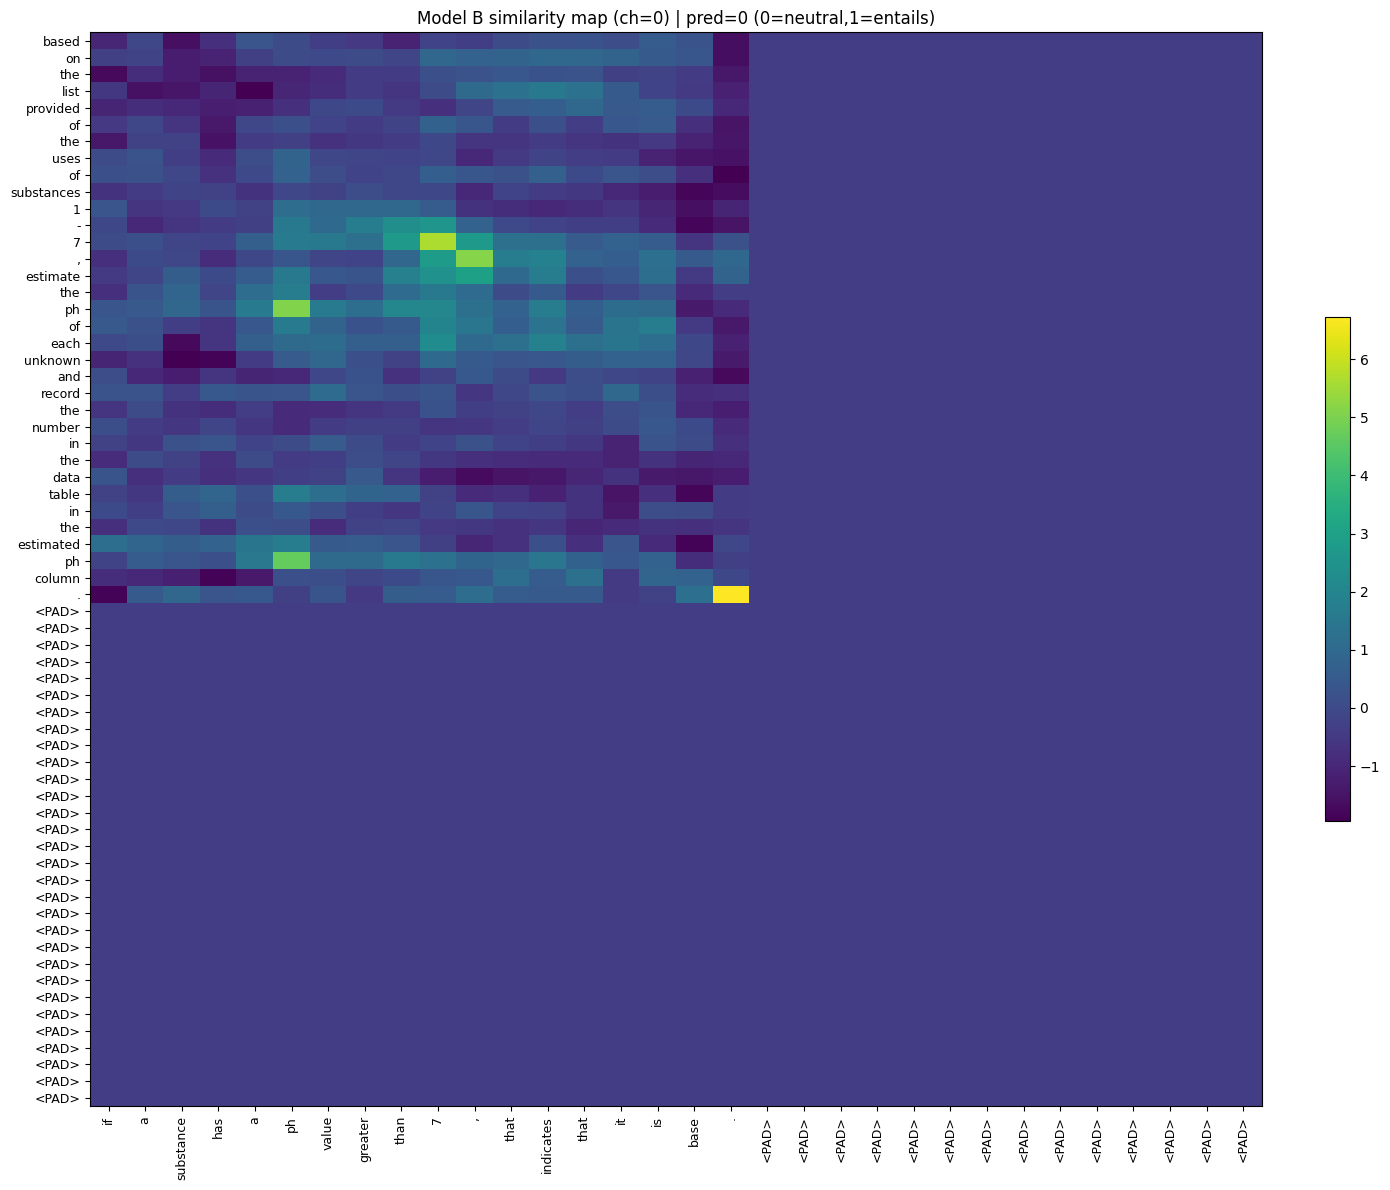

In [ ]:
# ==== Cell 20: Similarity heatmap for Model B ====
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_similarity_map_modelB(
    model, ex, stoi, itos,
    channel=0, max_p=MAX_P, max_h=MAX_H, device=DEVICE,
    unk_token='UNK', pad_token='PAD',
    save_path="simmap_b.png", show=True, cmap='viridis'
):
    """
    Render one similarity channel from Model B.
    Assumes: model(P, H, return_maps=True) -> (logits, S[B, C, Lp, Lh])
    """
    unk_id = stoi.get(unk_token, 0)
    pad_id = stoi.get(pad_token, 0)

    p_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["premise"])]
    h_ids = [stoi.get(t, unk_id) for t in simple_tok(ex["hypothesis"])]
    P = torch.tensor([pad_to_len(p_ids, max_p, pad_id)], dtype=torch.long, device=device)
    H = torch.tensor([pad_to_len(h_ids, max_h, pad_id)], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        logits, S = model(P, H, return_maps=True)
        pred = int(logits.argmax(1).item())

    def decode(ids):
        toks = [itos.get(i, unk_token) for i in ids]
        try:
            cut = toks.index(pad_token); toks = toks[:cut]
        except ValueError:
            pass
        return toks

    p_toks = decode(P[0].tolist())
    h_toks = decode(H[0].tolist())
    M = S[0, channel, :len(p_toks), :len(h_toks)].detach().cpu().numpy()

    fig_w = min(14, 0.5 * len(h_toks) + 4)
    fig_h = min(12, 0.5 * len(p_toks) + 4)
    plt.figure(figsize=(fig_w, fig_h))
    im = plt.imshow(M, aspect='auto', cmap=cmap)
    plt.colorbar(im, fraction=0.020)
    plt.yticks(range(len(p_toks)), p_toks, fontsize=9)
    plt.xticks(range(len(h_toks)), h_toks, rotation=90, fontsize=9)
    plt.title(f"Model B similarity map (ch={channel}) | pred={pred} (0=neutral,1=entails)")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# Example call:
visualize_similarity_map_modelB(
    modelB, test_raw[0], stoi, itos, channel=0,
    save_path="simmap_b.png", show=True
)


In [ ]:
# ==== Cell 21: B ablation - cos-only vs cos+dot ====
def quick_run_B(use_dot):
    m = BiLSTM2DCNN(
        vocab_size=len(stoi), emb_dim=EMB_DIM, hid=HID,
        pad_idx=stoi[PAD], use_cos=True, use_dot=use_dot, use_bilinear=False,
        num_filters=32, kernel_size=3, pool_out=16, dropout=0.3, standardize=True
    ).to(DEVICE)
    _, v, _ = fit(
        m, train_loader, valid_loader,
        epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE,
        class_weights=None, label_smooth=0.0
    )
    acc, _, _ = evaluate_with_preds(m, test_loader)
    print(f"cos+dot={use_dot} -> VAL={v:.4f} TEST={acc:.4f}")
    return v, acc

quick_run_B(False)
quick_run_B(True)


/usr/local/lib/python3.12/dist-packages/torch/functional.py:422: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return _VF.einsum(equation, operands)  # type: ignore[attr-defined]
/tmp/ipython-input-3648102403.py:62: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you h

[Ep 01] train loss 0.6599 acc 0.7098 | valid loss 0.5607 acc 0.7178
[Ep 02] train loss 0.3971 acc 0.8247 | valid loss 0.5780 acc 0.7155
[Ep 03] train loss 0.3134 acc 0.8682 | valid loss 0.6473 acc 0.7285
[Ep 04] train loss 0.2513 acc 0.8963 | valid loss 0.7829 acc 0.7101
[Ep 05] train loss 0.2043 acc 0.9190 | valid loss 0.8104 acc 0.7147
[Ep 06] train loss 0.1593 acc 0.9378 | valid loss 0.9203 acc 0.7216
[Ep 07] train loss 0.1215 acc 0.9542 | valid loss 1.0654 acc 0.7262
[Ep 08] train loss 0.1001 acc 0.9618 | valid loss 1.4265 acc 0.7101
Early stopping.
cos+dot=False -> VAL=0.7285 TEST=0.7437
[Ep 01] train loss 0.6512 acc 0.7159 | valid loss 0.6133 acc 0.7124
[Ep 02] train loss 0.4129 acc 0.8218 | valid loss 0.5987 acc 0.7086
[Ep 03] train loss 0.3338 acc 0.8614 | valid loss 0.5346 acc 0.7285
[Ep 04] train loss 0.2728 acc 0.8926 | valid loss 0.6841 acc 0.7117
[Ep 05] train loss 0.2195 acc 0.9145 | valid loss 0.6765 acc 0.7316
[Ep 06] train loss 0.1761 acc 0.9312 | valid loss 0.7923 acc

(0.7384969332466828, np.float64(0.7638758231420508))

In [ ]:
# ==== Cell 22: B ablation - k=5 / pool=32 / no_cnn ====
def train_eval_B_variant(desc,
                         use_cos=True, use_dot=False, use_bilinear=False,
                         kernel_size=3, pool_out=16,
                         num_filters=32, dropout=0.3):
    m = BiLSTM2DCNN(
        vocab_size=len(stoi), emb_dim=EMB_DIM, hid=HID, pad_idx=stoi[PAD],
        use_cos=use_cos, use_dot=use_dot, use_bilinear=use_bilinear,
        num_filters=num_filters, kernel_size=kernel_size, pool_out=pool_out,
        dropout=dropout, standardize=True
    ).to(DEVICE)
    _, v, _ = fit(
        m, train_loader, valid_loader,
        epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE,
        class_weights=None, label_smooth=0.0
    )
    acc, _, _ = evaluate_with_preds(m, test_loader)
    print(f"B-abl | {desc:12s} -> VAL={v:.4f} TEST={acc:.4f}")
    return v, acc

train_eval_B_variant("kernel5", kernel_size=5)
train_eval_B_variant("pool32",  pool_out=32)
train_eval_B_variant("no_cnn",  use_cos=True, use_dot=False, num_filters=32)


/tmp/ipython-input-3648102403.py:62: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(pm.unsqueeze(2), hm.unsqueeze(1))  # (B, Lp, Lh)


[Ep 01] train loss 0.6942 acc 0.6556 | valid loss 0.6541 acc 0.6311
[Ep 02] train loss 0.4564 acc 0.7888 | valid loss 0.6022 acc 0.6963
[Ep 03] train loss 0.3560 acc 0.8495 | valid loss 0.5776 acc 0.7032
[Ep 04] train loss 0.2842 acc 0.8882 | valid loss 0.5923 acc 0.7385
[Ep 05] train loss 0.2238 acc 0.9118 | valid loss 0.7105 acc 0.7278
[Ep 06] train loss 0.1815 acc 0.9308 | valid loss 0.8133 acc 0.7201
[Ep 07] train loss 0.1405 acc 0.9462 | valid loss 0.9281 acc 0.7293
[Ep 08] train loss 0.1045 acc 0.9612 | valid loss 1.0024 acc 0.7209
[Ep 09] train loss 0.0847 acc 0.9699 | valid loss 1.1715 acc 0.7255
Early stopping.
B-abl | kernel5      -> VAL=0.7385 TEST=0.7427
[Ep 01] train loss 0.9190 acc 0.6982 | valid loss 0.6267 acc 0.6687
[Ep 02] train loss 0.4177 acc 0.8128 | valid loss 0.6688 acc 0.6687
[Ep 03] train loss 0.3421 acc 0.8556 | valid loss 0.6997 acc 0.7147
[Ep 04] train loss 0.2792 acc 0.8867 | valid loss 0.7940 acc 0.6917
[Ep 05] train loss 0.2293 acc 0.9090 | valid loss 0.8

(0.7131901844147525, np.float64(0.7276575729068674))

In [ ]:
# ==== Cell 23: Sequence length ablation for Model A ====
import numpy as np, random, torch
from torch.utils.data import DataLoader

def make_loaders_with_lengths(max_p, max_h, batch=BATCH):
    def pad_to_len_local(ids, L, pad=0):
        return ids[:L] + [pad] * max(0, L - len(ids))
    def collate_len(batch):
        Ps, Hs, Ys = [], [], []
        for p, h, y in batch:
            Ps.append(pad_to_len_local(p, max_p))
            Hs.append(pad_to_len_local(h, max_h))
            Ys.append(y if y is not None else -1)
        return (torch.tensor(Ps, dtype=torch.long),
                torch.tensor(Hs, dtype=torch.long),
                torch.tensor(Ys, dtype=torch.long))
    g2 = torch.Generator(); g2.manual_seed(SEED)
    tr = DataLoader(train_ds, batch_size=batch, shuffle=True,  collate_fn=collate_len,
                    num_workers=0, generator=g2)
    va = DataLoader(valid_ds, batch_size=batch, shuffle=False, collate_fn=collate_len,
                    num_workers=0)
    te = DataLoader(test_ds,  batch_size=batch, shuffle=False, collate_fn=collate_len,
                    num_workers=0)
    return tr, va, te

def print_md_table(rows, header):
    print("| " + " | ".join(header) + " |")
    print("|" + "|".join(["-" * (len(h)+2) for h in header]) + "|")
    for r in rows:
        print("| " + " | ".join(str(x) for x in r) + " |")

def run_len_ablation_A():
    variants = [(48,24), (64,32), (80,40)]
    out = []
    for mp, mh in variants:
        torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
        tr, va, te = make_loaders_with_lengths(mp, mh)
        m = SiameseBiLSTM(vocab_size=vocab_size, emb_dim=EMB_DIM, hid=HID,
                          emb_matrix=emb_matrix, dropout=0.3, pool_mode='concat').to(DEVICE)
        _, v, _ = fit(m, tr, va, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY,
                      patience=PATIENCE, class_weights=None, label_smooth=0.0)
        acc, _, _ = evaluate_with_preds(m, te)
        out.append((f"{mp}/{mh}", round(v,4), round(acc,4)))
    print_md_table(out, ["MAX_P/MAX_H", "Val", "Test"])
    import json
    with open("/content/a_seq_len_ablation.json","w") as f:
        json.dump([{"max_p_h": nm, "val": v, "test": t} for nm, v, t in out], f, indent=2)
    print("Saved -> /content/a_seq_len_ablation.json")

run_len_ablation_A()


[Ep 01] train loss 0.5385 acc 0.7228 | valid loss 0.5243 acc 0.7385
[Ep 02] train loss 0.4180 acc 0.8104 | valid loss 0.4848 acc 0.7730
[Ep 03] train loss 0.3462 acc 0.8494 | valid loss 0.4949 acc 0.7607
[Ep 04] train loss 0.3048 acc 0.8701 | valid loss 0.5137 acc 0.7546
[Ep 05] train loss 0.2712 acc 0.8881 | valid loss 0.4853 acc 0.7699
[Ep 06] train loss 0.2462 acc 0.8981 | valid loss 0.4733 acc 0.7722
[Ep 07] train loss 0.2216 acc 0.9077 | valid loss 0.4759 acc 0.7784
[Ep 08] train loss 0.1956 acc 0.9210 | valid loss 0.5372 acc 0.7776
[Ep 09] train loss 0.1792 acc 0.9270 | valid loss 0.5555 acc 0.7768
[Ep 10] train loss 0.1612 acc 0.9356 | valid loss 0.5364 acc 0.7768
[Ep 11] train loss 0.1392 acc 0.9446 | valid loss 0.5345 acc 0.7914
[Ep 12] train loss 0.1303 acc 0.9489 | valid loss 0.5694 acc 0.7684
[Ep 13] train loss 0.1118 acc 0.9576 | valid loss 0.5703 acc 0.7807
[Ep 14] train loss 0.1064 acc 0.9578 | valid loss 0.6224 acc 0.7807
[Ep 15] train loss 0.0900 acc 0.9663 | valid los

In [ ]:
# ==== Cell 24: Hidden/Embedding sweep on Model A ====
import numpy as np, random, torch

def run_A_hid_emb_sweep(h_list=(96,128,160), emb_list=(50,100,200)):
    rows = []
    for h in h_list:
        for e in emb_list:
            torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
            m = SiameseBiLSTM(vocab_size=vocab_size, emb_dim=e, hid=h,
                              emb_matrix=None, dropout=0.3, pool_mode='concat').to(DEVICE)
            _, v, _ = fit(m, train_loader, valid_loader, epochs=EPOCHS, lr=LR,
                          weight_decay=WEIGHT_DECAY, patience=PATIENCE,
                          class_weights=None, label_smooth=0.0)
            acc, _, _ = evaluate_with_preds(m, test_loader)
            rows.append((h, e, round(v,4), round(acc,4)))
    print("| Hid | Emb | Val  | Test |")
    print("|-----|-----|------|------|")
    for h,e,v,t in rows:
        print(f"| {h:3d} | {e:3d} | {v:0.4f} | {t:0.4f} |")
    import json
    with open("/content/a_hid_emb_sweep.json","w") as f:
        json.dump([{"hid":h,"emb":e,"val":v,"test":t} for h,e,v,t in rows], f, indent=2)
    print("Saved -> /content/a_hid_emb_sweep.json")

run_A_hid_emb_sweep()


[Ep 01] train loss 0.5660 acc 0.7028 | valid loss 0.5385 acc 0.7224
[Ep 02] train loss 0.4571 acc 0.7858 | valid loss 0.5358 acc 0.7308
[Ep 03] train loss 0.4069 acc 0.8157 | valid loss 0.5116 acc 0.7477
[Ep 04] train loss 0.3684 acc 0.8368 | valid loss 0.5254 acc 0.7462
[Ep 05] train loss 0.3360 acc 0.8544 | valid loss 0.5017 acc 0.7607
[Ep 06] train loss 0.3205 acc 0.8614 | valid loss 0.5503 acc 0.7385
[Ep 07] train loss 0.2952 acc 0.8742 | valid loss 0.6193 acc 0.7224
[Ep 08] train loss 0.2817 acc 0.8802 | valid loss 0.5874 acc 0.7393
[Ep 09] train loss 0.2675 acc 0.8879 | valid loss 0.5271 acc 0.7538
[Ep 10] train loss 0.2553 acc 0.8926 | valid loss 0.5797 acc 0.7423
Early stopping.
[Ep 01] train loss 0.5480 acc 0.7137 | valid loss 0.5129 acc 0.7462
[Ep 02] train loss 0.4155 acc 0.8102 | valid loss 0.4596 acc 0.7707
[Ep 03] train loss 0.3508 acc 0.8458 | valid loss 0.4672 acc 0.7753
[Ep 04] train loss 0.3137 acc 0.8675 | valid loss 0.4999 acc 0.7577
[Ep 05] train loss 0.2882 acc 0.

In [ ]:
# ==== Cell 25 (NEW): Consolidated summary (reads JSONs if exist) ====
import os, json

def load_json_if(path, fallback=None):
    return json.load(open(path)) if os.path.exists(path) else fallback

sum_A = {"model":"A","val": float(best_val), "ckpt": "/content/modelA_best.pt"}
sum_B = {"model":"B","val": float(best_valB),"ckpt": "/content/modelB_best.pt"}
sum_C = {"model":"C","val": float(best_valC),"ckpt": "/content/modelC_best.pt"}

print("Main runs (best val acc):", sum_A, sum_B, sum_C)

print("\nArtifacts saved:")
for p in ["/content/attn_ablation_table.json",
          "/content/c_additional_ablation.json",
          "/content/a_seq_len_ablation.json",
          "/content/a_hid_emb_sweep.json"]:
    print("  ", p, "->", os.path.exists(p))


Main runs (best val acc): {'model': 'A', 'val': 0.7898773013448422, 'ckpt': '/content/modelA_best.pt'} {'model': 'B', 'val': 0.7269938653963475, 'ckpt': '/content/modelB_best.pt'} {'model': 'C', 'val': 0.7607361963190185, 'ckpt': '/content/modelC_best.pt'}

Artifacts saved:
   /content/attn_ablation_table.json -> True
   /content/c_additional_ablation.json -> True
   /content/a_seq_len_ablation.json -> True
   /content/a_hid_emb_sweep.json -> True


In [ ]:
# ==== Cell 26: Download rendered figures from Colab ====
import os
from google.colab import files

to_get = [
    "attn_single_c.png",
    "attn_success.png",
    "attn_failure.png",
    "simmap_b.png",
]
for name in to_get:
    if os.path.exists(name):
        files.download(name)

# Alternatively, zip them into one file:
!zip -r figs_colab.zip attn_single_c.png attn_success.png attn_failure.png simmap_b.png
files.download("figs_colab.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

In [ ]:
# ==== OOP Demo: trainer wrapper + per-model summary (no retrain) ====
class NLITrainer:
    def __init__(self, model, name="model"):
        self.model = model
        self.name = name

    def test_summary(self, loader):
        acc, y_true, y_pred = evaluate_with_preds(self.model, loader)
        import numpy as np
        cm = np.zeros((2,2), dtype=int)
        for t,p in zip(y_true, y_pred): cm[t,p]+=1
        prec, rec, f1 = [], [], []
        for c in [0,1]:
            tp = cm[c,c]; fp = cm[:,c].sum()-tp; fn = cm[c,:].sum()-tp
            p = tp/(tp+fp+1e-12); r = tp/(tp+fn+1e-12)
            prec.append(p); rec.append(r); f1.append(2*p*r/(p+r+1e-12))
        print(f"[{self.name}] acc={acc:.4f}  macroP/R/F1={np.mean(prec):.4f}/{np.mean(rec):.4f}/{np.mean(f1):.4f}")
        print("CM:\n", cm)
        return acc

NLITrainer(model,  "Model A").test_summary(test_loader)
NLITrainer(modelB, "Model B").test_summary(test_loader)
NLITrainer(modelC, "Model C").test_summary(test_loader)


[Model A] acc=0.7817  macroP/R/F1=0.7735/0.7656/0.7688
CM:
 [[1083  201]
 [ 263  579]]
[Model B] acc=0.7380  macroP/R/F1=0.7266/0.7185/0.7215
CM:
 [[1043  241]
 [ 316  526]]


/tmp/ipython-input-3648102403.py:62: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return torch.bmm(pm.unsqueeze(2), hm.unsqueeze(1))  # (B, Lp, Lh)
/tmp/ipython-input-1567827658.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable de

[Model C] acc=0.7563  macroP/R/F1=0.7588/0.7218/0.7293
CM:
 [[1140  144]
 [ 374  468]]


np.float64(0.7563499529633114)